In [53]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background') #si ton vs-code est noir

# Data preparation

In [2]:
data_2013 = pd.read_csv("./data/2012-2013 Solar home electricity data v2.csv", header = 1)

In [3]:
#count the number of NA (non-actual) in 'Row Quality' column:
print(f"number of NA (non-actual) row: {data_2013['Row Quality'].count()}")

number of NA (non-actual) row: 0


In [4]:
#store customer infos
data_cust = data_2013.groupby(by='Customer')
cust_info = pd.DataFrame()
cust_info['Customer ID'] = data_cust['Customer'].first()
cust_info['Generator Capacity'] = data_cust['Generator Capacity'].first()
cust_info['Postcode'] = data_cust['Postcode'].first()

In [42]:
#rearrange dataframe
meltdate = data_2013.melt(id_vars = ['Customer', 'Consumption Category', 'date'], value_vars = data_2013.columns[5:53], var_name = 'time', value_name = 'power')
unstk = meltdate.pivot_table('power', ['Customer', 'date', "time"], 'Consumption Category')

In [43]:
unstk.reset_index(level = [0, 1, 2], inplace = True)
unstk['Timestamp'] = pd.to_datetime(unstk['date'] + unstk['time'], format='%d/%m/%Y%H:%M')
unstk.pop('date')
unstk.pop('time')
df = unstk.groupby(by = 'Timestamp').sum()
#unstk.pop('Consumption Category')
df.reset_index(inplace=True)
#df.set_index('Timestamp', inplace=True)
df.pop('Customer')
df

Consumption Category,Timestamp,CL,GC,GG
0,2012-07-01 00:00:00,86.601,102.973,0.015
1,2012-07-01 00:30:00,95.035,83.167,0.024
2,2012-07-01 01:00:00,79.293,76.027,0.049
3,2012-07-01 01:30:00,73.399,75.627,0.027
4,2012-07-01 02:00:00,58.312,65.588,0.038
...,...,...,...,...
17515,2013-06-30 21:30:00,4.682,160.788,0.031
17516,2013-06-30 22:00:00,16.506,154.692,0.019
17517,2013-06-30 22:30:00,24.024,145.467,0.008
17518,2013-06-30 23:00:00,26.264,137.357,0.007


Two letter code each meaning the following:

GC = General Consumption for electricity supplied all the time
(primary tariff, either inclining block or time of use rates),
excluding solar generation and controlled load supply

CL = Controlled Load Consumption (Off peak 1 or 2 tariffs)

GG = Gross Generation for electricity generated by the solar
system with a gross metering configuration, measured separately
to household loads

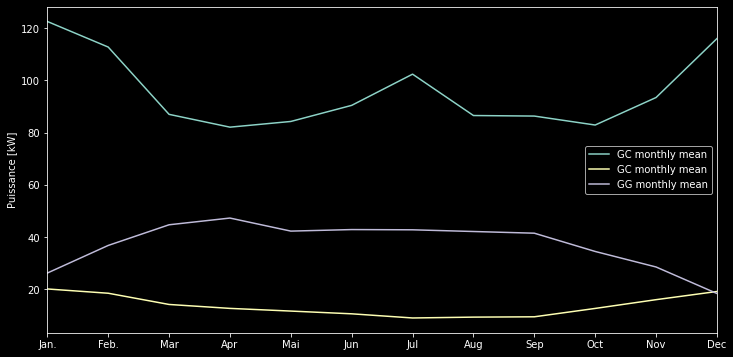

In [54]:
groupby_month = df.groupby(pd.Grouper(key='Timestamp', freq='M'))
data_month = [group for _,group in groupby_month]
GC_month, CL_month, GG_month = list(), list(), list()
for month in data_month:
    GC_month.append(month['GC'].mean())
    CL_month.append(month['CL'].mean())
    GG_month.append(month['GG'].mean())

fig = plt.figure(figsize=(12,6))
lin = np.linspace(0, 12, 12)
plt.plot(lin, GC_month, label = 'GC monthly mean')
plt.plot(lin, CL_month, label = 'GC monthly mean')
plt.plot(lin, GG_month, label = 'GG monthly mean')

plt.legend()
plt.xlim([0, 12])
plt.xticks(lin, ['Jan.', 'Feb.', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Puissance [kW]')
plt.show()

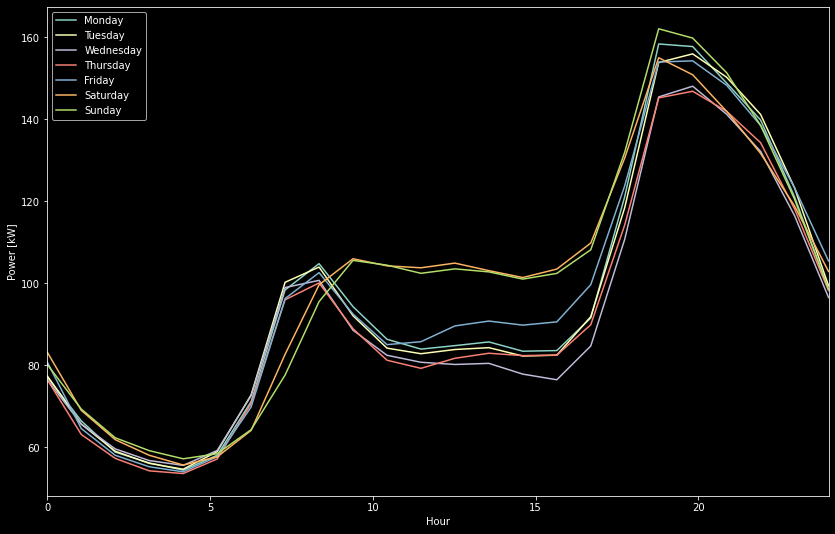

In [94]:
#analysis per day
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#seasons_name = ['Winter', 'Summer', 'Interseason']
fig = plt.figure(figsize=(14, 9))
data_day = df.groupby(df['Timestamp'].dt.weekday)
list_day = [day for (_, day) in data_day]
for i, day in enumerate(list_day):
    data_half = day.groupby(day['Timestamp'].dt.hour).mean() #is it power (mean) or energy (sum) ?
    power_half = data_half['GC']
    plt.plot(np.linspace(0, 24, 24), power_half, label = day_of_week[i])
plt.xlim([0, 24])
plt.xlabel('Hour')
plt.ylabel('Power [kW]')
plt.legend(loc = 2)
plt.show()